In [1]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, accuracy_score
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
df = pd.read_csv('./dados/cleaned_dataset.csv')

In [3]:
df = df.drop(columns=['Id'])

In [4]:
X = df[['Score', 'Gender', 'Age', 'Assets', 'Products', 'Active']]
y = df['Churned']

In [5]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [6]:
def xgb_cv(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree, alpha, lambda_):
    try:
        model = xgb.XGBClassifier(
            max_depth=int(max_depth),
            learning_rate=learning_rate,
            n_estimators=int(n_estimators),
            gamma=gamma,
            min_child_weight=int(min_child_weight),
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            objective='binary:logistic',
            eval_metric='logloss',
            reg_alpha=alpha,
            reg_lambda=lambda_,
            random_state=42
        )
        
        # Perform cross-validation and return the mean accuracy
        cv_result = cross_val_score(model, X_train, y_train, cv=3, scoring=make_scorer(accuracy_score))
        return cv_result.mean()
    
    except ValueError as e:
        print("Error encountered during function evaluation:", e)
        return None  # Return None so Bayesian Optimization skips this iteration


In [7]:
# Set the parameter bounds for Bayesian Optimization
param_bounds = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 500),
    'gamma': (0, 5),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'alpha': (0, 10),
    'lambda_': (0, 10)                   # L2 regularization term (reg_lambda)
}


In [8]:
# Run Bayesian Optimization
optimizer = BayesianOptimization(f=xgb_cv, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   |   alpha   | colsam... |   gamma   |  lambda_  | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.8398    | 3.745     | 0.9754    | 3.66      | 5.987     | 0.05525   | 4.092     | 1.523     | 439.8     | 0.8006    |
| 2         | 0.7976    | 7.081     | 0.5103    | 4.85      | 8.324     | 0.07158   | 4.273     | 2.651     | 186.9     | 0.7624    |
| 3         | 0.8276    | 4.319     | 0.6456    | 3.059     | 1.395     | 0.09472   | 5.565     | 5.105     | 403.3     | 0.5998    |
| 4         | 0.8242    | 5.142     | 0.7962    | 0.2323    | 6.075     | 0.05945   | 3.455     | 9.54      | 484.5     | 0.9042    |
| 5         | 0.8409    | 3.046     | 0.5488    | 3.421     | 4.402     | 0.04539   | 6.466     | 1.309     | 459.2     | 0.6294    |
| 6         | 0.8242    | 0.492     | 0.9639    | 0.2729    | 

In [9]:
best_params = optimizer.max['params']

best_model = xgb.XGBClassifier(
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),  # Convert to integer
    min_child_weight=int(best_params['min_child_weight']),  # Convert to integer
    n_estimators=int(best_params['n_estimators']),  # Convert to integer
    subsample=best_params['subsample'],
    alpha=best_params['alpha'],
    lambda_=best_params['lambda_'],
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42
)

In [10]:
# Fit the model on the training data
best_model.fit(X_train, y_train)

/home/lopes/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:17:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=0.5553513807764443, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7982024931657878, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None,
              gamma=4.500293962227733, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda_=0.25437810917599557,
              learning_rate=0.10964780748207918, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=433, n_jobs=None, ...)

In [11]:
# Make predictions on the test data
y_pred_class = best_model.predict(X_test)

In [12]:
# Compute predicted probabilities for the positive class
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

In [13]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [14]:
# Calculate the Area Under the Curve (AUC)
auc_score = roc_auc_score(y_test, y_pred_proba)

In [15]:
cnf_matrix = confusion_matrix(y_test, y_pred_class)

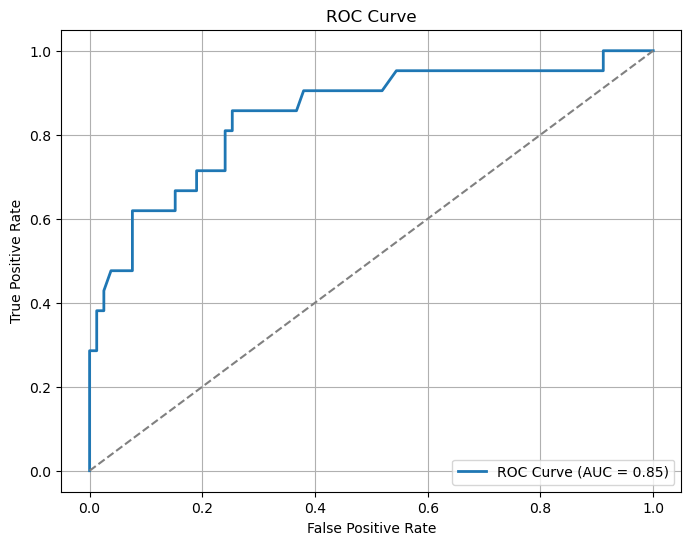

In [16]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal reference line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
print(f"AUC Score: {auc_score:.2f}")

AUC Score: 0.85


In [18]:
print('Confusion Matrix:')
print(cnf_matrix)
print('\nAccuracy', accuracy_score(y_test, y_pred_class))

Confusion Matrix:
[[78  1]
 [13  8]]

Accuracy 0.86


In [19]:
cnf_table = pd.DataFrame(data=cnf_matrix, index=['Non-Churned', 'Churned'], columns=['Non_churned(pred)', 'Churned(pred)'])

In [20]:
print(cnf_table)

             Non_churned(pred)  Churned(pred)
Non-Churned                 78              1
Churned                     13              8


In [21]:
print(classification_report(y_test, y_pred_class, target_names=['Non Churned', 'Churned']))

              precision    recall  f1-score   support

 Non Churned       0.86      0.99      0.92        79
     Churned       0.89      0.38      0.53        21

    accuracy                           0.86       100
   macro avg       0.87      0.68      0.73       100
weighted avg       0.86      0.86      0.84       100

